In [1]:
import pandas as pd
import numpy as np
import pickle
from keras.models import load_model
from keras.applications import Xception

import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import precision_score

D:\Users\122156\Anaconda3\envs\tensorflow\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Users\122156\Anaconda3\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
D:\Users\122156\Anaconda3\envs\tensorflow\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras import Model

# structure data
model1 = Sequential()
model1.add(Dense(16, activation="relu", input_shape=(19,)))
model1.add(Dense(4, activation="relu"))
model1.add(Dense(1, activation="sigmoid"))
model1.load_weights('joint_fusion_structure.hdf5')

# image
base = Xception(include_top=True, weights='imagenet',)
x = Dense(512, kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4), activation='linear')(base.output)
x = Dropout(0.5)(x)
x = Dense(32, kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4), activation='linear')(x)
x = Dense(1, activation='linear')(x)
model2 = Model(inputs=base.inputs, outputs=x)
model2.load_weights('../CXR/xception_mse0.9885_val_mse1.4219.hdf5')

In [3]:
# model for structure data
minput = model1.get_layer('dense')
moutput = model1.get_layer('dense_1')
model_structure = Model(inputs=minput.input, outputs=moutput.output)
# model_structure.summary()

# model for CXR image
x = model2.layers[-2].output
outputs = Dense(32, activation="softmax", name="final_predictions")(x)
model_image = Model(inputs = model2.input, outputs = outputs)
# model_image.summary()

In [4]:
# concat model_structure and model_image
import tensorflow as tf

# model_structure
input_1 = tf.keras.layers.Input(shape=(19,))
dense_1 = model_structure(input_1)

# model_image
input_2 = tf.keras.layers.Input(shape=(299, 299, 3))
dense_2 = model_image(input_2)

# concatenate
concat = tf.keras.layers.Concatenate()([dense_1, dense_2])

# output layer
output = tf.keras.layers.Dense(units=1, activation='sigmoid')(concat)

# full model
full_model = tf.keras.Model(inputs=[input_1, input_2], outputs=[output])

print(full_model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 19)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 4)            388         input_2[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 32)           23440464    input_3[0][0]                    
____________________________________________________________________________________________

In [5]:
train_ID_score = pd.read_excel("../CXR/train_test_split.xlsx", sheet_name = 'train')
test_ID_score = pd.read_excel("../CXR/train_test_split.xlsx", sheet_name = 'test')

train_ID_list = [int(i.split('_')[0]) for i in list(train_ID_score.ID)]
test_ID_list = [int(i.split('_')[0]) for i in list(test_ID_score.ID)]

In [6]:
### NTUH structure dataset
dataset = pd.read_csv('../concat_influ8_severity_score.csv')
dataset = dataset[['ID', 'Gender', 'Age', 'BMI', 'Diastolic_blood_pressure', 'Heart_rate', 
                   'Respiratory_rate', 'Creatinine', 'CRP', 'Hemoglobin', 'Bicarbonate', 
                   'PCO2', 'pH', 'Platelet', 'PO2',  'Blood_urea_nitrogen', 
                   'Lactic_acid', 'INR', 'Glucose', 'Hematocrit', 'Survival_30']]

In [7]:
import cv2
import os
### NTUH image dataset
DIR = '../CXR/influ_xray/original_data'
training_data1 = []
training_data2 = []
testing_data1 = []
testing_data2 = []
training_label = []
testing_label = []

# train
for img in train_ID_list:
    if (os.path.exists(os.path.join(DIR,'{}_1.jpeg'.format(img)))) & (img in list(dataset.ID)):
        image = cv2.imread(os.path.join(DIR,'{}_1.jpeg'.format(img)),cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        image = cv2.resize(image, (299, 299))
        training_data1.append(np.array(dataset[dataset['ID'] == int(img)].iloc[0])[1:-1])
        training_data2.append(image/255.0)
        training_label.append(np.array(dataset[dataset['ID'] == int(img)].iloc[0])[-1])

# test 
for img in test_ID_list:
    if (os.path.exists(os.path.join(DIR,'{}_1.jpeg'.format(img)))) & (img in list(dataset.ID)):
        image = cv2.imread(os.path.join(DIR,'{}_1.jpeg'.format(img)),cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        image = cv2.resize(image, (299, 299))
        testing_data1.append(np.array(dataset[dataset['ID'] == int(img)].iloc[0])[1:-1])
        testing_data2.append(image/255.0)
        testing_label.append(list(dataset[dataset['ID'] == int(img)].iloc[0])[-1])

In [8]:
train = pd.DataFrame({'training_data1': training_data1, 'training_data2': training_data2, 'training_label': training_label})
count_class_0, count_class_1 = train.training_label.value_counts()
df_class_0 = train[train['training_label'] == 0]
df_class_1 = train[train['training_label'] == 1]
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

training_data1 = np.array(df_test_over['training_data1'].to_list())
training_data2 = np.array(df_test_over['training_data2'].to_list())
training_label = np.array(df_test_over['training_label'].to_list())

In [9]:
print('training image(structure)', np.array(training_data1).shape, 'training image(img)', np.array(training_data2).shape, 'training label', np.array(training_label).shape, 
      'testing image(structure)', np.array(testing_data1).shape, 'testing image(img)', np.array(testing_data2).shape, 'testing label', np.array(testing_label).shape)

training image(structure) (1322, 19) training image(img) (1322, 299, 299, 3) training label (1322,) testing image(structure) (309, 19) testing image(img) (309, 299, 299, 3) testing label (309,)


In [10]:
# # Compile the model
# full_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# # Train the model
# input1 = np.array(training_data1)
# input2 = np.array(training_data2)
# full_model.fit([input1, input2], np.array(training_label), batch_size=12, epochs=20, validation_split=0.2, callbacks = [keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)])

In [11]:
from sklearn.metrics import confusion_matrix
def evaluation(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    sensitivity = TP / (TP+FN+1e8)
    specificity = TN / (TN+FP+1e8)
    print(sensitivity)
    print(specificity)

In [12]:
# full_model.save('joint_fusion_acc0.6841_accval0.9208.hdf5')
full_model.load_weights('joint_fusion_acc0.6841_accval0.9208.hdf5')

AUC: 0.555
Acc: 0.359
sensitivity: 0.667
specificity: 0.337
precision: 0.068
recall: 0.667
F1: 0.124
PPV:: 0.068
NPV:: 0.933
brier score: 0.278
PR score: 0.068
The area under the recall precision curve: 0.445
              precision    recall  f1-score   support

           0       0.93      0.34      0.49       288
           1       0.07      0.67      0.12        21

    accuracy                           0.36       309
   macro avg       0.50      0.50      0.31       309
weighted avg       0.87      0.36      0.47       309



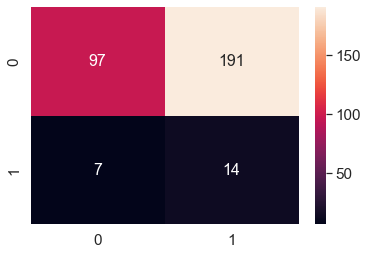

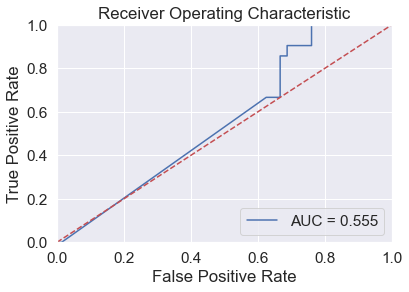

In [13]:
### NTUH dataset
y_test = np.array(testing_label)
y_prob = full_model.predict([np.array(testing_data1), np.array(testing_data2)])
y_pred = np.where(y_prob > 0.5957, 1,0).flatten()

cm = metrics.confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp+fn+1e-8)
specificity = tn / (tn+fp+1e-8)
precision = tp/(tp+fp+1e-8)
recall = tp/(tp+fn+1e-8)
f1 = (2*precision*recall)/(precision+recall)
auc = metrics.roc_auc_score(y_test, y_prob)
acc = metrics.accuracy_score(y_test, y_pred)
ppv = tp / (tp+fp)
npv = tn / (fn+tn)

print('AUC: {:.3f}'.format(auc))
print('Acc: {:.3f}'.format(acc))
print('sensitivity: {:.3f}'.format(sensitivity))
print('specificity: {:.3f}'.format(specificity))
print('precision: {:.3f}'.format(precision))
print('recall: {:.3f}'.format(recall))
print('F1: {:.3f}'.format(f1))
print('PPV:: {:.3f}'.format(ppv))
print('NPV:: {:.3f}'.format(npv))
print('brier score: {:.3f}'.format(brier_score_loss(y_test, y_prob)))
print('PR score: {:.3f}'.format(precision_score(y_test, y_pred)))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
AUC_PR = metrics.auc(tpr, fpr)
print('The area under the recall precision curve: {:.3f}'.format(AUC_PR))

print(classification_report(y_test, y_pred, labels=[0,1]))

### Confusion Matrics
sns.set(font_scale = 1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
plt.show()

# ### Recall Precision curves
# disp = plot_precision_recall_curve(full_model, [np.array(testing_data1), np.array(testing_data2)], y_test)
# disp.ax_.set_title('2-class Precision-Recall curve')
# disp.ax_.legend(loc = 'upper right')
# plt.show()

### ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc_score(y_test, y_prob))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [14]:
### Italian dataset
external_dataset = pd.read_csv("../concat_italy_severity_score.csv")
# ##
# external_dataset = external_dataset[external_dataset.isnull().sum(axis=1) <= 5]
# ##
external_dataset = external_dataset[['ID number', 'Gender', 'Age', 'BMI', 'DBP (mmHg)', 'Heart rate ', 'RR', 
                                  'Creatinine ', 'CRP', 'Hb', 'HCO3-', 'pCo2', 'Ph',
                                  'PLT', 'pO2', 'BUN ', 'Lactate', 'INR ', 'Glycemia', 
                                  'HCT', 'severity_score','30 days mortality (0 alive, 1 death)']]
external_dataset.columns = ['ID', 'Gender', 'Age', 'BMI', 'Diastolic_blood_pressure', 'Heart_rate', 
                   'Respiratory_rate', 'Creatinine', 'CRP', 'Hemoglobin', 'Bicarbonate', 
                   'PCO2', 'pH', 'Platelet', 'PO2',  'Blood_urea_nitrogen', 
                   'Lactic_acid', 'INR', 'Glucose', 'Hematocrit', 'severity_score', 'Survival_30']
external_dataset['Gender'] = external_dataset['Gender'].replace('F',0).replace('M',1)
external_dataset['BMI'] = external_dataset['BMI'].replace("Normal", "18.5")
external_dataset['BMI'] = external_dataset['BMI'].replace("Overweight", "21.75")
external_dataset['BMI'] = external_dataset['BMI'].replace("Obese ", "27.5")
external_dataset['BMI'] = external_dataset['BMI'].replace("Underweight", "30")
external_dataset['Gender'] = pd.to_numeric(external_dataset['Gender'], errors='coerce')
external_dataset['BMI'] = pd.to_numeric(external_dataset['BMI'], errors='coerce')

external_dataset = external_dataset[['ID', 'Gender', 'Age', 'BMI', 'Diastolic_blood_pressure', 'Heart_rate', 
                                     'Respiratory_rate', 'Creatinine', 'CRP', 'Hemoglobin', 'Bicarbonate', 
                                     'PCO2', 'pH', 'Platelet', 'PO2',  'Blood_urea_nitrogen', 
                                     'Lactic_acid', 'INR', 'Glucose', 'Hematocrit', 'Survival_30']]

external_dataset = external_dataset.fillna(round(external_dataset.mean(), 2))

D:\Users\122156\AppData\Local\Temp/ipykernel_2608/282472389.py:27: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  external_dataset = external_dataset.fillna(round(external_dataset.mean(), 2))


In [15]:
import cv2
import os
### Italian image dataset
DIR = '../CXR_italy'
external_data1 = []
external_data2 = []
external_label = []

# external
for img in os.listdir(DIR):
    if img[:-7].lower() in list(external_dataset.ID):
        image = cv2.imread(os.path.join(DIR,'{}'.format(img)),cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        image = cv2.resize(image, (299, 299))
        external_data1.append(np.array(external_dataset[external_dataset['ID'] == img[:-7]].iloc[0])[1:-1])
        external_data2.append(image/255.0)
        external_label.append(np.array(external_dataset[external_dataset['ID'] == img[:-7]].iloc[0])[-1])

In [16]:
y_test_ex = np.array(external_label)
y_prob_ex = full_model.predict([np.array(external_data1).astype(np.float32), np.array(external_data2).astype(np.float32)])
y_pred_ex = np.where(y_prob_ex > 0.5957, 1,0).flatten()

AUC: 0.639
Acc: 0.401
sensitivity: 0.882
specificity: 0.364
precision: 0.097
recall: 0.882
F1: 0.174
PPV:: 0.097
NPV:: 0.976
brier score: 0.279
PR score: 0.097
The area under the recall precision curve: 0.361
              precision    recall  f1-score   support

           0       0.98      0.36      0.53       220
           1       0.10      0.88      0.17        17

    accuracy                           0.40       237
   macro avg       0.54      0.62      0.35       237
weighted avg       0.91      0.40      0.50       237



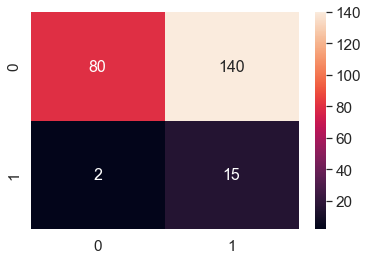

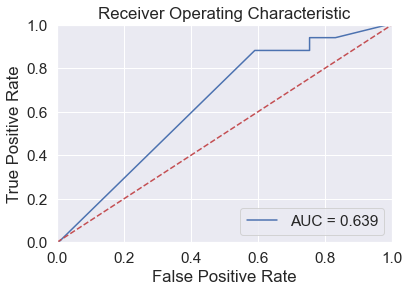

In [21]:
cm = metrics.confusion_matrix(y_test_ex, y_pred_ex)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp+fn+1e-8)
specificity = tn / (tn+fp+1e-8)
precision = tp/(tp+fp+1e-8)
recall = tp/(tp+fn+1e-8)
f1 = (2*precision*recall)/(precision+recall)
auc = metrics.roc_auc_score(y_test_ex, y_prob_ex)
acc = metrics.accuracy_score(y_test_ex, y_pred_ex)
ppv = tp / (tp+fp)
npv = tn / (fn+tn)

print('AUC: {:.3f}'.format(auc))
print('Acc: {:.3f}'.format(acc))
print('sensitivity: {:.3f}'.format(sensitivity))
print('specificity: {:.3f}'.format(specificity))
print('precision: {:.3f}'.format(precision))
print('recall: {:.3f}'.format(recall))
print('F1: {:.3f}'.format(f1))
print('PPV:: {:.3f}'.format(ppv))
print('NPV:: {:.3f}'.format(npv))
print('brier score: {:.3f}'.format(brier_score_loss(y_test_ex, y_prob_ex)))
print('PR score: {:.3f}'.format(precision_score(y_test_ex, y_pred_ex)))

fpr, tpr, thresholds = metrics.roc_curve(y_test_ex, y_prob_ex)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
AUC_PR = metrics.auc(tpr, fpr)
print('The area under the recall precision curve: {:.3f}'.format(AUC_PR))

print(classification_report(y_test_ex, y_pred_ex, labels=[0,1]))

### Confusion Matrics
sns.set(font_scale = 1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
plt.show()

# ### Recall Precision curves
# disp = plot_precision_recall_curve(full_model, [np.array(testing_data1), np.array(testing_data2)], y_test)
# disp.ax_.set_title('2-class Precision-Recall curve')
# disp.ax_.legend(loc = 'upper right')
# plt.show()

### ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc_score(y_test_ex, y_prob_ex))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()